In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

from ada_const import *
from ada_context import *
from ada_imports import *

# Data Fetching

First we load mentions and events datasets into two DataFrames using `spark.read.csv()` using a schema built according to the GDELT 2.1 documentation.

In [2]:
from ada_dataIO import *

events = loadGDELT(EVENTS)
mentions = loadGDELT(MENTIONS)

# Data Selection and Cleaning

The `cleanEvents()` and `cleanMentions()` functions select the columns we will be using and transform the `ActionGeo_CountryCode` values from FISP-10 codes to iso codes.

We also register the two DataFrames as tables in the SQL context.

The values of `AvgTone`, `QuadClass` and `GoldsteinScale` columns are already in correct range (-100 to 100 for `AvgTone`, 1 to 4 for `QuadScale` and -10 to 10 for `GoldsteinScale`) thus we don't need to do any further cleaning.

In [3]:
from ada_dataCleaner import *


events = cleanEvents(events)
mentions = cleanMentions(mentions)

events.registerTempTable('events')
mentions.registerTempTable('mentions')


In [4]:
mentions.printSchema()

root
 |-- GLOBALEVENTID: long (nullable = true)
 |-- EventTimeDate: timestamp (nullable = true)
 |-- MentionTimeDate: timestamp (nullable = true)
 |-- MentionType: long (nullable = true)
 |-- Confidence: long (nullable = true)
 |-- MentionSourceName: string (nullable = true)



In [5]:
events.printSchema()

root
 |-- GLOBALEVENTID: long (nullable = true)
 |-- date: date (nullable = true)
 |-- Day_Date: integer (nullable = true)
 |-- Month_Date: integer (nullable = true)
 |-- Year_Date: string (nullable = true)
 |-- MonthYear_Date: string (nullable = true)
 |-- FractionDate: float (nullable = true)
 |-- QuadClass: long (nullable = true)
 |-- GoldsteinScale: float (nullable = true)
 |-- AvgTone: float (nullable = true)
 |-- ActionGeo_CountryCode: string (nullable = true)



# Data Exploration

For exploration of the database we will be using a sample of the data provided on the cluster. These csv files were represent roughly 10% of each database, the chosen samples were spread over time in order to have a more reliable estimation of distribution of the data across time.

In [6]:
print('{} events are reported in our events sample dataset'.format(events.count()))
print('{} mentions are reported in our mentions sample dataset'.format(mentions.count()))

4186 events are reported in our events sample dataset
12165 mentions are reported in our mentions sample dataset


## Event database
# Origin of our data

The news reports we will be using accross this project are gathered from different news source types : 

- Web sources (1)
- Broadcasts, prints, other offline sources (2)
- CORE archives (3)
- DTIC archives (4)
- JSTOR archives (5)
- NonTextual sources (6)

Let's explore the origin of the news reports we will be analysing :


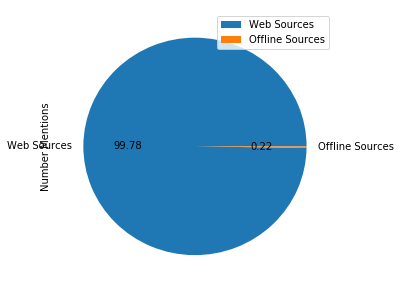

In [7]:
labels_val = ['Web Sources','Offline Sources','CORE Archives','DTIC Archives','JSTOR Archives','Non Textual Sources']

def get_labels(labels):   
    return [x for i,x in enumerate(labels_val) if (i+1) in labels]
    
def get_sources(df_mentions):
    
    sources = df_mentions.groupby('MentionType').agg(count('GLOBALEVENTID').alias('Number Mentions')).orderBy('MentionType')
    
    mentions_list = list(sources.select('Number Mentions').toPandas()['Number Mentions'])
    source_list = list(sources.select('MentionType').toPandas()['MentionType'])

    return pd.DataFrame({'Number Mentions': mentions_list},index= source_list)

sources = get_sources(mentions)
sources.plot.pie(y='Number Mentions', autopct='%.2f',figsize=(5, 5),labels=get_labels(list(sources.index)))


As seen above almost all sources are websources.

# Confidence in our data

The mentions dataframe provide a estimation of the confidence at which a event was extracted from a news report. If a news report is focused on a event, the confidence ratio at which this event is detected, is higher than in news report where the event is only briefly mentionned.

As a first insight in our data, let's see the distribution of this ratio accross our mention dataframe

In [8]:
# Getting the percentage of mentions for each confidence value
def get_confidence(df_mentions):
    
    total_mentions = df_mentions.count()
    udf = UserDefinedFunction(lambda x: x/total_mentions, DoubleType())

    confidence = df_mentions.groupby('Confidence').agg(count('GLOBALEVENTID').alias('Number Mentions')).orderBy('Confidence')
    confidence = confidence.select([udf(column).alias('Percentage of Mentions') if column == 'Number Mentions' else column for column in confidence.columns])
    
    return confidence

In [9]:
confidence = get_confidence(mentions).toPandas()

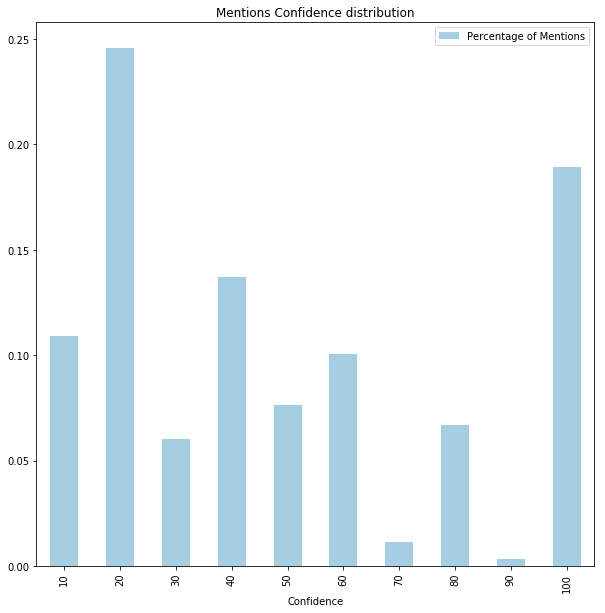

In [10]:
confidence.plot.bar(x='Confidence', y='Percentage of Mentions', figsize=(10, 10), colormap='Paired',title = 'Mentions Confidence distribution')

As seen above, a consequent part of mentions reported in the mentions csv files have a low confidence ratio. 
We decided to investigate if this repartition was different depending on mention source type.

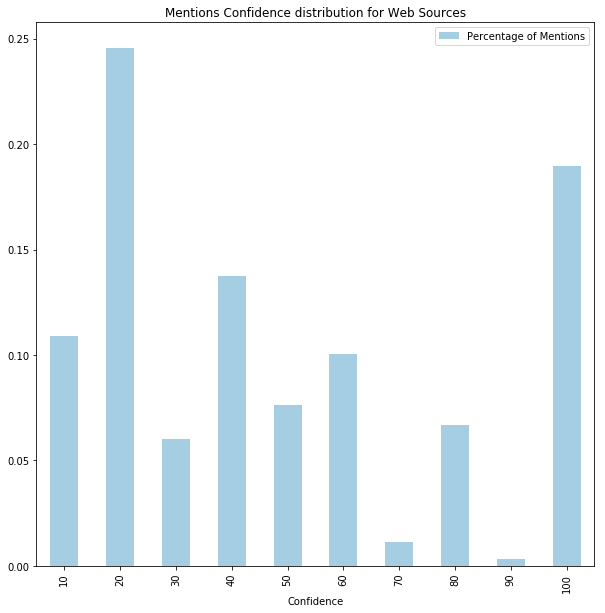

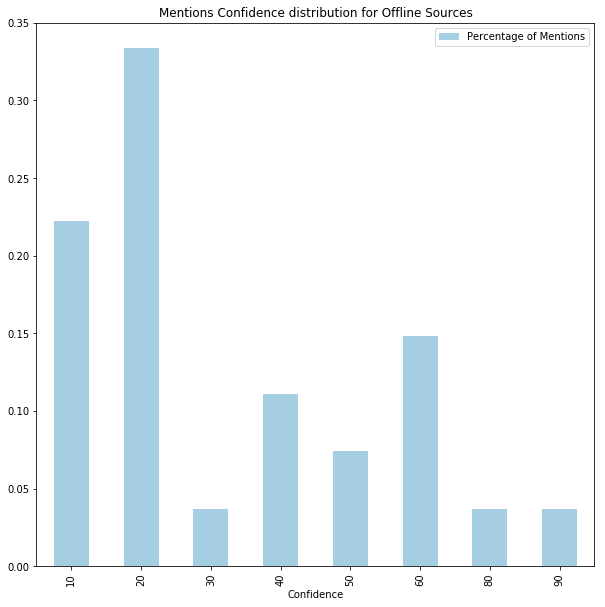

In [11]:
for index,label in enumerate(labels_val):

    sources_index = mentions['MentionType'] == str(index+1)
    sources = mentions[['GLOBALEVENTID','MentionType', 'Confidence']][sources_index]
    
    if not sources.toPandas().empty :
        confidence = get_confidence(sources).toPandas()
        confidence.plot.bar(x='Confidence', y='Percentage of Mentions', figsize=(10, 10), colormap='Paired',title = 'Mentions Confidence distribution for '+label)

The previous plots show that roughly 35 % of mentions have a confidence level of 20% or less. This lack of confidence is slightly stronger for offline sources that only represet less than 1% of mentions sources. 
To get more reliable results through out our projets, the desicion was made to consider only news mentions with a confidence level of at least 20%.

In [12]:
# TO BE RUN ONCE VALUES ARE NUMS
def get_goodConfidence(df_mentions):
   
    index = df_mentions['Confidence'] > 20

    return df_mentions[df_mentions.schema.names][index]

#new_mentions = get_goodConfidence(mentions)
#new_mentions.show()

In [13]:
print('{} mentions are reported in our mentions sample dataset'.format(mentions.count()))

12165 mentions are reported in our mentions sample dataset


# Sources

We would like to have an overview of the different medias which report the news. We thus look at the medias which have more publications over the 2 years. 

In [14]:
sources = mentions.select('MentionSourceName').groupBy('MentionSourceName').count().orderBy(desc('count'))
sources.show(30)

+--------------------+-----+
|   MentionSourceName|count|
+--------------------+-----+
|           yahoo.com|  256|
|      thenews.com.pk|  251|
|         rappler.com|  166|
|            wboc.com|  121|
|      independent.ie|  114|
|         reuters.com|  113|
|   foreignpolicy.com|  107|
|    osundefender.org|  105|
|       firstpost.com|  103|
|  couriermail.com.au|  100|
| thefrontierpost.com|  100|
|informationcleari...|   97|
|voiceofalexandria...|   85|
|   thealpenanews.com|   78|
|batemansbaypost.c...|   77|
|         stuff.co.nz|   76|
|          smh.com.au|   76|
|kiamaindependent....|   75|
|             wnd.com|   73|
|rapidcityjournal.com|   72|
|     thisdaylive.com|   70|
|     mailtribune.com|   69|
|victorharbortimes...|   69|
| theridgenews.com.au|   67|
|     asianewsnet.net|   67|
|     perthnow.com.au|   67|
|newyorkstatesman.com|   67|
|maitlandmercury.c...|   66|
|southcoastregiste...|   65|
|blayneychronicle....|   64|
+--------------------+-----+
only showing t

We see that among the most prevalent medias are many american news sources like the broadcast and internet radio iheart.com (USA, Canada, New Zealand, Australia), the search engine yahoo.com, the newspaper/radio/television news agency ap.org, the american broadcasting company abc7 and other american news relating medias (news-sentinel, wnd, news12, tucson, miamiherald, sfgate, missoulian, washingtonpost, huffingtonpost).

The most prevalent medias also count the british international news agency reuters.com and newspaper DailyMail.co.uk, the Palestine news agency Wafa, the australian Courier Mail, the indian indiatimes, the chinese news agency xinhuanet.

# Event Time
We would like to display the evolution of human activity and media coverage throughout the months, to see how the data is distributed and to visualize any particular behavior with respect to time.

In [15]:
# When was our data collected ? 
def get_period(df_events):
    
    start = df_events.select('Day_DATE').orderBy('Day_DATE').head()
    stop = df_events.select('Day_DATE').orderBy(desc('Day_DATE')).head()
    
    return start[0], stop[0]

In [16]:
# Problem
start,stop = get_period(events)
print('Data collection starts {} and stops {}'.format(start,stop))

Data collection starts 12 and stops 20


### Human activity worldwide throughout the months
We want to represent the distribution of human activity throughout the months for a country.

In [17]:
# WORLDWIDE
def get_events_worldwide(events_df):
    
    events_worldwide =  events_df.groupBy('MonthYear_Date').count().orderBy('MonthYear_Date')
    
    udf = UserDefinedFunction(lambda x: datetime.strptime(x,'%Y%m').strftime('%m-%Y'))
    return events_worldwide.select([udf(column).alias('Month_Year') if column == 'MonthYear_Date' else column for column in events_worldwide.columns])
   

In [18]:
events_worldwide_time = get_events_worldwide(events)

,Month_Year,count
0,02-2014,59
1,01-2015,26
2,02-2015,4101


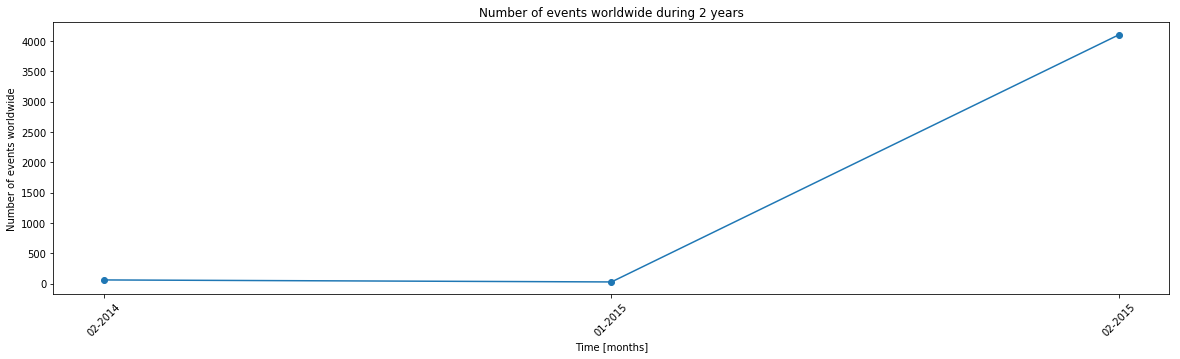

In [20]:

events_worldwide_time = events_worldwide_time.toPandas()
fig = plt.subplots(figsize=(20,5))
plt.plot(events_worldwide_time['Month_Year'], events_worldwide_time['count'],marker='o')
plt.xlabel('Time [months]')
plt.ylabel('Number of events worldwide')
plt.xticks(rotation=45)
plt.title('Number of events worldwide during 2 years')

events_worldwide_time.head()

The database contains events which are located prior in time to the beginning of the recording of mentions in the database, in February 2015. This in fact is due to the fact that mentions reference to events which just happened but also to events which happened in the past, and which will thus be registered in the database. However, since most of the events are referenced in the news right after they happened, these events will have less mentions than the ones which happened after the beginning of the recording. We thus choose to remove the mentions to events which happened prior to the beginning of the recording, in order to have an accurate idea of the total number of mentions per event.

The last events recorded are in november 2017, which is consistent with the end time of the database we have access to.  

### Media coverage worldwide throughout the months
We want to represent the distribution of the worldwide media coverage throughout the months. 

In [21]:
# WORLDWIDE
udf_mention1 = UserDefinedFunction(lambda x: x.strftime('%Y%m'))
udf_mention2 = UserDefinedFunction(lambda x: datetime.strptime(x,'%Y%m').strftime('%m-%Y'))

def get_media_coverage_worldwide(mentions_df) :
    
    mentions_Year_Month = mentions_df.select([udf_mention1(column).alias('Year_Month_Mention') if column == 'MentionTimeDate' else column for column in mentions_df.columns])
    mentions_year_month = mentions_Year_Month.groupBy('Year_Month_Mention').count().orderBy('Year_Month_Mention') 
    mentions_month_year = mentions_year_month.select([udf_mention2(column).alias('Month_Year_Mention') if column == 'Year_Month_Mention' else column for column in mentions_year_month.columns])
    
    return mentions_month_year


In [22]:
mentions_worldwide_time = get_media_coverage_worldwide(mentions)

Text(0.5,1,'Number of mentions worldwide during 2 years')

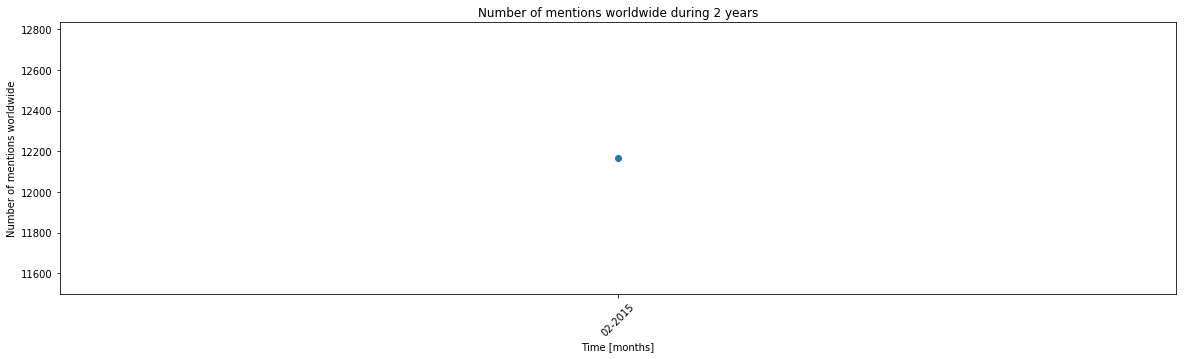

In [23]:
mentions_worldwide_time = mentions_worldwide_time.toPandas()
fig = plt.subplots(figsize=(20,5))
plt.plot(mentions_worldwide_time['Month_Year_Mention'], mentions_worldwide_time['count'],marker='o')
plt.xlabel('Time [months]')
plt.ylabel('Number of mentions worldwide')
plt.xticks(rotation=45)
plt.title('Number of mentions worldwide during 2 years')


The first mentions were in February 2015 and the last mentions were in November 2017, which is consistent with the time range of recording that we have access to, from February 18th 2015 at 11pm to November 23th 2017 at 8am. 

### Evolution of mentions for an event througout the months
Now that we have had a rough overview of how events and mentions are distributed througout time, we would like to see how the mentions for a specific event are distributed througout time. We choose to select events which are mentioned a lot and which can give an actual idea of what happens across time, unlike small events which are only mentioned right after they happened.

In [24]:
# get the 50 events which are the most mentioned during the 2 years
largest_events = mentions.groupBy('GLOBALEVENTID').count().orderBy(desc('count')).limit(50)
largest_events.show()

+-------------+-----+
|GLOBALEVENTID|count|
+-------------+-----+
|    410469317|   46|
|    410469318|   46|
|    410425589|   35|
|    410432577|   28|
|    410431783|   28|
|    410474732|   26|
|    410476226|   26|
|    410425025|   24|
|    410481549|   24|
|    410479759|   24|
|    410481550|   24|
|    410479592|   24|
|    410424364|   24|
|    410480841|   24|
|    410479836|   24|
|    410480613|   24|
|    410480845|   24|
|    410479823|   24|
|    410479860|   24|
|    410479835|   24|
+-------------+-----+
only showing top 20 rows



In [25]:
udf_mention1 = UserDefinedFunction(lambda x: x.strftime('%Y%m'))
udf_mention2 = UserDefinedFunction(lambda x: datetime.strptime(x,'%Y%m').strftime('%m-%Y'))

# finds each mention of the most mentioned events
largest_events_time = largest_events.select('GLOBALEVENTID').join(mentions.select('GLOBALEVENTID','MentionTimeDate'), 'GLOBALEVENTID')
# finds the number of mentions per month for the most mentioned events (converts to a conveniable time format)
largest_events_Year_Month = largest_events_time.select([udf_mention1(column).alias('Year_Month_Mention') if column == 'MentionTimeDate' else column for column in largest_events_time.columns])
largest_events_year_month = largest_events_Year_Month.groupBy('Year_Month_Mention','GLOBALEVENTID').count().orderBy('Year_Month_Mention') 
largest_events_month_year = largest_events_year_month.select([udf_mention2(column).alias('Month_Year_Mention') if column == 'Year_Month_Mention' else column for column in largest_events_year_month.columns])
    
largest_events_month_year.show(10)


+------------------+-------------+-----+
|Month_Year_Mention|GLOBALEVENTID|count|
+------------------+-------------+-----+
|           02-2015|    410424364|   24|
|           02-2015|    410426624|   22|
|           02-2015|    410479826|   24|
|           02-2015|    410452709|   18|
|           02-2015|    410468532|   23|
|           02-2015|    410479860|   24|
|           02-2015|    410426747|   18|
|           02-2015|    410474682|   20|
|           02-2015|    410451559|   18|
|           02-2015|    410425025|   24|
+------------------+-------------+-----+
only showing top 10 rows



In [26]:
largest_events_month_year.toPandas().duplicated(subset='GLOBALEVENTID', keep='first').unique()

array([False])

We see here that since we are only considering 15 minutes of events per month, this analysis is not really significative. We would need data over a whole month to do a deeper analysis of the mentions of an event througout time. Indeed here, all the mentions for an event are in the same 15 minutes. 

# Mentions , Mediatic Coverge and Mediatic Attention

Our project will be centered around the evaluation of the biais of medias towards specific locations and event types worldwide. 
To achieve this a indicator of media coverage and media attention should be defined. This will be achieved by using the mentions database with reports every 15 minutes all new report of events in the news. Each row in this database records a acticle/news report which mentioned at least once a specific event. 

#### Media Coverage :
Media coverage will be defined as the number of mentions in news report a event will receive within 120 days (4 months) posterior to its occurence. As explicited above, this time period was set to avoid the biais of the date of occurence of the event. Indeed, our databse records mentions from February 2015 to November 2017. Each event should be considered on an equivalent period of time. 
As explicited above, another restriction will be applied to our mentions database : only mentions with a confidence ratio above 20 will be considered

#### Mediatic Attention:
In order to grasp the level of attention perceived by a event on the mediactic scene, we should compute the mediatic attention index.  This index will be considered as the ratio between media coverage and the total amount of mentions reported in the database during the equivalent period of time. This normalisation procedure allows to avoid a biased perception and compare the level of atention perceived by events. 

Let's first observe the distribution of mediatic coverage by event within our database : 

In [27]:
def get_delay(df_mentions):
    # Get delay between event time and mention time
    
    timeFmt = "yyyy-MM-dd'T'HH:mm:ss.SSS"
    timeDiff = (unix_timestamp('MentionTimeDate', format=timeFmt) - unix_timestamp('EventTimeDate', format=timeFmt))
    
    return df_mentions.withColumn("Mention delay", timeDiff)

def restric_cov(df_mentions, days_threshold):
    # Narrow down mentions to 2 month posterior to event mentions
    
    restric_index = df_mentions['Mention Delay'] <= days_threshold*24*3600
    
    return df_mentions[df_mentions.schema.names][restric_index].sort('GLOBALEVENTID')

mentions = restric_cov(get_delay(mentions),120)
mentions.count()

12165

In [28]:
def get_media_cov(df_mentions):
    # Computing the mediatic coverage of each event in the mentions database
    
    return df_mentions.groupby('GLOBALEVENTID').agg(count('GLOBALEVENTID').alias('Number Mentions'))

med_cov = get_media_cov(mentions)
med_cov.select('Number Mentions').describe().show()

+-------+------------------+
|summary|   Number Mentions|
+-------+------------------+
|  count|              7478|
|   mean|1.6267718641347955|
| stddev|2.4175398998057145|
|    min|                 1|
|    max|                46|
+-------+------------------+



Text(0.5,1,'Distribution of mediatic coverage per event')

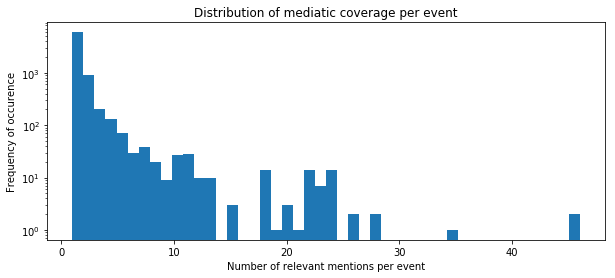

In [29]:
#Showing the distribution of mediatic coverage in database
med_cov = med_cov.toPandas()
fig = plt.subplots(figsize=(10,4))
plt.hist(med_cov['Number Mentions'],bins = med_cov['Number Mentions'].max())
plt.yscale('log')
plt.xlabel('Number of relevant mentions per event')
plt.ylabel('Frequency of occurence')
plt.title('Distribution of mediatic coverage per event')


In the mentions database, each row records a mention of an event in a news report. As understood in the documentation provided, each mentions reports to a single news report where the event was mentionned at least once. 
As seen above the most frequent number of mentions is one, a large amount of events receive very low mediatic coverage.

In [30]:
#Work in progress : mediatic attention function
mentions = mentions.alias('mentions')
events = events.alias('events')
timeFmt = "yyyy-MM-dd'T'HH:mm:ss.SSS"
timeDiff = (unix_timestamp('MentionTimeDate', format=timeFmt))


x = events.join(mentions, events['GLOBALEVENTID'] == mentions['GLOBALEVENTID'],how = 'left').select(['mentions.*']).sort('GLOBALEVENTID')
x = x.withColumn("UnixMentionTime", timeDiff).select(['GLOBALEVENTID','UnixMentionTime'])
x.show(1000)

def get_x(time_mention):

    ans = x[x.schema.names][time_mention <= x['UnixEventTime'] <= (time_mention +(3600*24*120))]
    ans.show()
    return ans

udf = UserDefinedFunction(lambda z: get_x(z).count())
# x = x.select([udf(column).alias('Total Number Mentions') if column == 'UnixMentionTime' else column for column in x.columns])   
    
# x.show()


+-------------+---------------+
|GLOBALEVENTID|UnixMentionTime|
+-------------+---------------+
|    410479387|     1424313000|
|    410479388|     1424313000|
|    410479389|     1424313000|
|    410479390|     1424313000|
|    410479391|     1424313000|
|    410479392|     1424313000|
|    410479393|     1424313000|
|    410479394|     1424313000|
|    410479395|     1424313000|
|    410479396|     1424313000|
|    410479397|     1424313000|
|    410479398|     1424313000|
|    410479398|     1424313000|
|    410479399|     1424313000|
|    410479399|     1424313000|
|    410479400|     1424313000|
|    410479400|     1424313000|
|    410479401|     1424313000|
|    410479401|     1424313000|
|    410479402|     1424313000|
|    410479403|     1424313000|
|    410479404|     1424313000|
|    410479405|     1424313000|
|    410479406|     1424313000|
|    410479407|     1424313900|
|    410479407|     1424313000|
|    410479407|     1424313900|
|    410479407|     1424313900|
|    410

# Geography
### Human activity per country (average over the 2 years)
We represented the distribution of events in the different countries over the 2 years, to see in which countries there seems to be more events taking place, according to the information related in the medias.

In [31]:
# returns the number of events per country over the 2 years
def get_events_country(df_events) : 
    df_events_countries = df_events.groupBy('ActionGeo_CountryCode').count().orderBy('count').toPandas()
    df_events_countries.columns = ['ActionGeo_CountryCode','human_activity']
    return df_events_countries

In [32]:
events_country = get_events_country(events)
events_country.tail(10)

,ActionGeo_CountryCode,human_activity
102,EI,75
103,CA,99
104,None,113
105,PH,115
106,CN,117
107,NG,148
108,AU,157
109,IN,189
110,PK,220
111,US,1592


Text(0.5,1,'Human activitites related through the medias across countries')

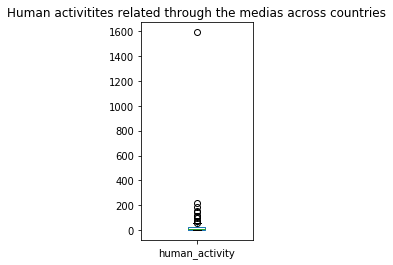

In [33]:
# boxplot of the number of events of each country
fig = plt.subplots(figsize=(2,4))
events_country.boxplot(column='human_activity', grid=False)
plt.title('Human activitites related through the medias across countries')

In [34]:
events_country.describe()

,human_activity
count,112.000000
mean,37.375000
std,153.221157
min,1.000000
25%,2.750000
50%,7.500000
75%,24.500000
max,1592.000000


In [35]:
# outlier countries in terms of human activity in the countries over the 2 years
outliers = events_country[(np.abs(events_country.human_activity-events_country.human_activity.mean()) > (3*events_country.human_activity.std()))]
outliers.head()

,ActionGeo_CountryCode,human_activity
111,US,1592


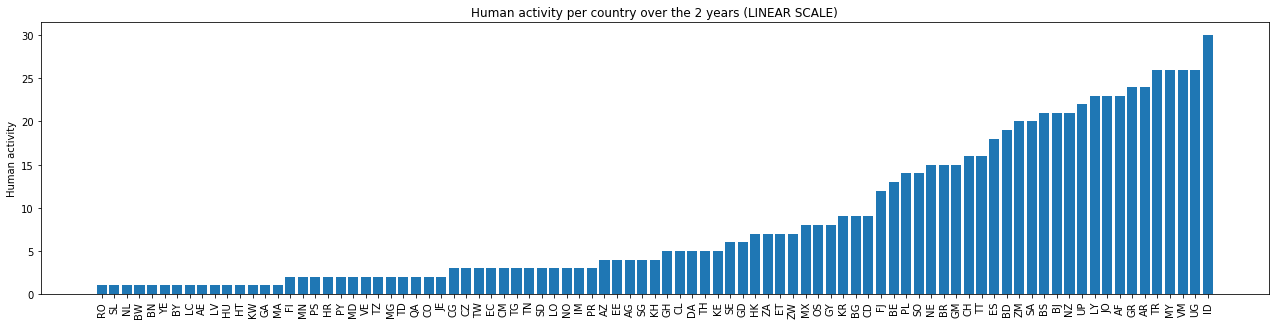

In [36]:
# represents the number of events over the 2 years for the countries in which less events took place (LINEAR SCALE)
events_country_less = events_country[events_country['human_activity']<33]
x_pos = np.arange(len(events_country_less['human_activity']))
fig, ax = plt.subplots(figsize=(22,5))
ax.bar(x_pos, events_country_less['human_activity'])
ax.set_xticks(x_pos)
ax.set_xticklabels(events_country_less['ActionGeo_CountryCode'])
ax.set_ylabel('Human activity')
ax.set_title("Human activity per country over the 2 years (LINEAR SCALE)")
plt.xticks(x_pos, events_country_less['ActionGeo_CountryCode'], rotation='vertical')
plt.show()

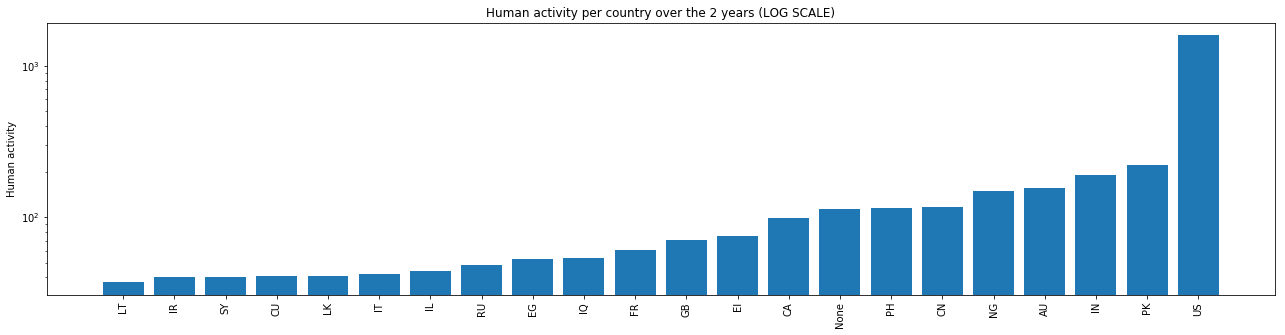

In [37]:
# represents the number of events over the 2 years for the countries in which more events took place (LOG SCALE)
events_country_more = events_country[events_country['human_activity']>33]
x_pos = np.arange(len(events_country_more['human_activity']))
fig, ax = plt.subplots(figsize=(22,5))
ax.bar(x_pos, events_country_more['human_activity'])
ax.set_yscale('log')
ax.set_xticks(x_pos)
ax.set_xticklabels(events_country_more['ActionGeo_CountryCode'])
ax.set_ylabel('Human activity')
ax.set_title("Human activity per country over the 2 years (LOG SCALE)")
plt.xticks(x_pos, events_country_more['ActionGeo_CountryCode'], rotation='vertical')
plt.show()

According to the informations related through the medias, the United States (US) seem to be the country where most of the human activity is taking place. Indeed, it is a clear outlier in the distribution of human activity, because its number of events is way above the median. Canada (CA) is also highly represented in terms of human activity. This might be because most of the news sources considered by the database come from the USA and will thus tend to display the events taking place in the country itself and in the bordering countries. 

What we also observe is that many events are associated with no country (None), which means that an important amount of events from the database are misclassified in terms of geographical location. However, since we have a huge amount of data, we chose to remove these events in the future, when we will represent features per country.

### Media coverage and mediatic attention per country (average over the 2 years)
We looked at the distribution of media coverage and mediatic attention in the countries, to have an idea of the countries which are more present in the news. 

In [38]:
# returns the media coverage for each country over the 2 years
def get_media_coverage_country(events_df,mentions_df) :
    
    # mentions per event
    mentions_count = mentions_df.groupBy('GLOBALEVENTID').count()
    country_count = mentions_count.join(events_df, 'GLOBALEVENTID')
    # mentions per country over the 2 years (= media coverage)
    country_count = country_count.groupBy('ActionGeo_CountryCode').sum('count').orderBy(desc('sum(count)'))
    country_count = country_count.toPandas()
    country_count.columns = ['ActionGeo_CountryCode','media_coverage']
    # total number of mentions for all the events
    total = mentions_df.join(events, 'GLOBALEVENTID').count()
    # percentage of mentions per country over worldwide mentions over the 2 years (= mediatic attention)
    country_count['media_attention'] = country_count['media_coverage'].multiply(100).divide(total)
    
    return country_count
    

In [39]:
media_countries = get_media_coverage_country(events, mentions)

In [40]:
media_countries.head(20)

,ActionGeo_CountryCode,media_coverage,media_attention
0,US,1815,34.335982
1,AU,569,10.764283
2,PK,257,4.861899
3,IN,221,4.180855
4,NG,159,3.007946
5,CN,139,2.629588
6,PH,132,2.497162
7,None,127,2.402573
8,IT,123,2.326901
9,CA,116,2.194476


Text(0.5,1,'Media coverage across countries')

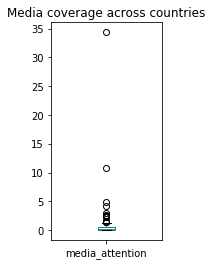

In [41]:
# boxplot of the media coverage of each country
fig = plt.subplots(figsize=(2,4))
media_countries.boxplot(column='media_attention', grid=False)
plt.title('Media coverage across countries')

In [42]:
media_countries.describe()

,media_coverage,media_attention
count,112.000000,112.000000
mean,47.196429,0.892857
std,181.466937,3.432973
min,1.000000,0.018918
25%,3.000000,0.056754
50%,9.000000,0.170261
75%,30.250000,0.572266
max,1815.000000,34.335982


In [43]:
# outlier countries in terms of media coverage over the 2 years
outliers = media_countries[(np.abs(media_countries.media_attention-media_countries.media_attention.mean()) > (3*media_countries.media_attention.std()))]
outliers.head()

,ActionGeo_CountryCode,media_coverage,media_attention
0,US,1815,34.335982


We see that the median and the 3rd quartile for the distribution of the media coverage are extremely low, but the mean is higher. This shows that there are some countries which are highly represented in the news and which pull the mean to higher value. We see that a clear outlier in the data is the US. This might be because, as we wrote earlier, most of the news sources are american and will thus get an easier access to the news in the US and in the bordering countries than to the news in more distant countries. On top of having a high media coverage, the USA have a high mediatic attention, meaning that they have a high weigh on the international mediatic stage.

We see that the countries which, according to the news, have the most events happening, are also the countries which get the most mediatic coverage and mediatic attention. For example United Kingdom (UK), Canada (CA), Australia (AS), China (CH), Pakistan (PK), Syria (SY) and Russsia (RS) are highly present in the medias. This is also consistent with the origins of the most prevalent media sources which are the UK, India, China and Australia. Indeed, these countries would naturally be more mentioned in the news if they have prominent news sources.

# Type of Event Biais

### Goldstein Ratio

One of the goal of our project is to assess the biais of media attention towards event type. Is their a direct correlation between the type of event and the mediatic attention is receives. 
A way to perform this is to use the Goldstein ratio which is a discrete numerical indicator between 10 and -10 that is directly link to the event type. The Goldstein ratio assigned to each event type is directly linked to potential impact of this event on the country's stability, the larger the index to more the event will act for the strenghting of the country. The lower the index values, the higher the chance that this event weaken's the country's stability.

Before performing statistical correlation between both index, let's explore the distribution of the Goldstein Ratio accross events reported by news. 

Documentation on goldstein ratio and cameo event types : 
- https://www.gdeltproject.org/data/lookups/CAMEO.eventcodes.txt
- https://www.gdeltproject.org/data/lookups/CAMEO.goldsteinscale.txt

In [44]:
#What is the distribution of the Goldstein Ratio accross events
events.select('GoldsteinScale').describe().show()

+-------+------------------+
|summary|    GoldsteinScale|
+-------+------------------+
|  count|              4186|
|   mean|0.3542044941643836|
| stddev|4.6663238791198385|
|    min|             -10.0|
|    max|              10.0|
+-------+------------------+



In [45]:
# Get the number of events reported for each Goldstein ratio value
def get_activity_byGoldsetin(df_events):
    
    total_event = df_events.count()
    udf = UserDefinedFunction(lambda x: x/total_event, DoubleType())
    
    goldstein = df_events.groupby('GoldsteinScale').agg(count('GLOBALEVENTID').alias('Number Events')).orderBy('GoldsteinScale')
    goldstein = goldstein.select([udf(column).alias('Percentage of Events') if column == 'Number Events' else column for column in goldstein.columns])
    
    return goldstein

goldstein = get_activity_byGoldsetin(events).toPandas()

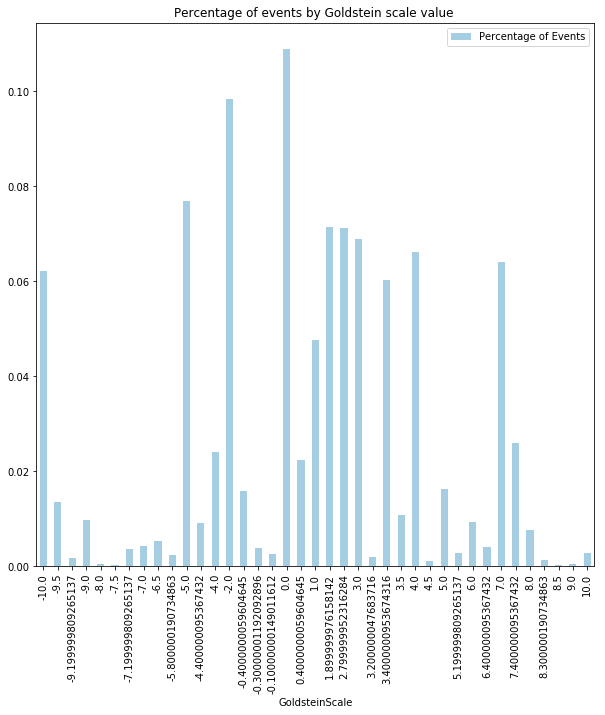

In [46]:
goldstein.plot.bar(x='GoldsteinScale', y='Percentage of Events', figsize=(10, 10), colormap='Paired',title = 'Percentage of events by Goldstein scale value ')

As seen above, the largest type Goldstein Scale displayed in the event population is 0.0. This means the largest category of event should theoretically have no on a country's stability. 
Let's know get insight on the distribution of Goldstein scale and therefore event type with mediatic coverage :

In [47]:
# Get the media coverage and goldstein ratio for each event
def get_cov_index(df_events,df_mentions,index):
    
    df_mentions = get_media_cov(df_mentions).alias('mentions')
    df_events = df_events.select(['GLOBALEVENTID',index]).alias('events')
    cov_index = df_events.join(df_mentions, df_events['GLOBALEVENTID'] == df_mentions['GLOBALEVENTID'],how = 'left').select(['events.'+index,'mentions.*']).sort('GoldsteinScale')

    return cov_index

goldstein2 = get_cov_index(events,mentions,'GoldsteinScale').toPandas()
    

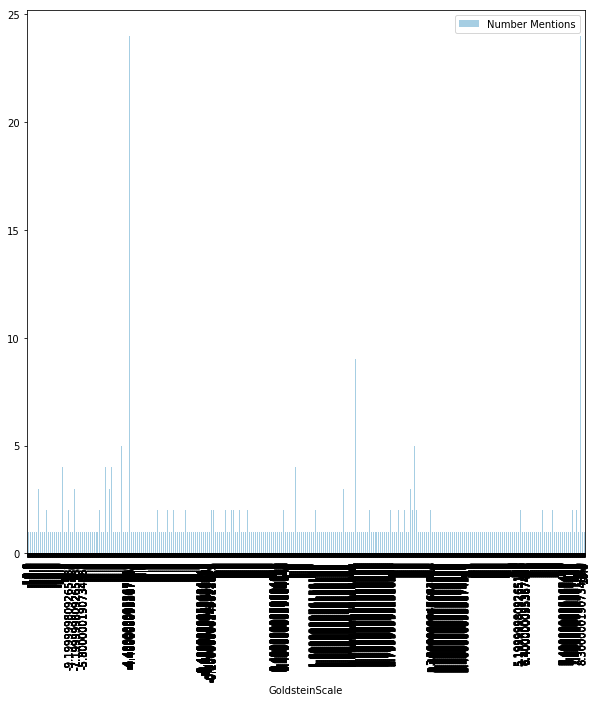

In [48]:
# Probleme a ne pas faire tourner
goldstein2.plot.bar(x='GoldsteinScale', y='Number Mentions', figsize=(10, 10), colormap='Paired')

### QuadClass

Another way to assess the biais of media coverage and attention depending on the event type is to use another way to classify events. The Quad Class features classifies event into four global catagories :
- Verbal cooperation
- Material cooperation
- Verbal conflict
- Material conflict

In order to have an idea of the distribution of the quad class in our dataset, we represented the percentage of events in each class :

In [49]:
#What is the distribution of the Quad Class type accross events
quad_val = ['Verbal Cooperation','Material Cooperation','Verbal Conflict','Material Conflict']
events.select('QuadClass').describe().show()

+-------+-----------------+
|summary|        QuadClass|
+-------+-----------------+
|  count|             4186|
|   mean|1.835164835164835|
| stddev| 1.15078942685509|
|    min|                1|
|    max|                4|
+-------+-----------------+



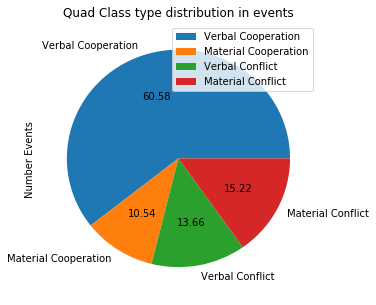

In [50]:
def get_class(labels):
    
    return [x for i,x in enumerate(quad_val) if (i+1) in labels]

def get_quad(df_events):
    
    return df_events.groupby('QuadClass').agg(count('GLOBALEVENTID').alias('Number Events')).orderBy('QuadClass')
    
def get_piechart_data(df,str1,str2):
    
    one_list = list(df.select(str1).toPandas()[str1])
    two_list = list(df.select(str2).toPandas()[str2])

    return pd.DataFrame({str1: one_list},index= two_list)

quad = get_piechart_data(get_quad(events),'Number Events','QuadClass')
quad.plot.pie(y='Number Events', autopct='%.2f',figsize=(5, 5),labels=get_class(list(quad.index)),title = 'Quad Class type distribution in events')

As shown above a majority of reported event relate Verbal Cooperation, the distribution between all Quad Class types is therefore not homogene. Most activities related by the news are not conflictual. We see though that more than 25% of the events related by the news are conflictual. 
The media attention index considered later on in our analysis should therefore take into consideration the inhomogenity of the distribution. The media coverage and (resp. attention) should be a ratio between number of mentions (resp. normalised number of mentions) per QuadClass type and the total number of event per QuadClass type. 

In [51]:
def get_cov_quad(df_events,df_mentions):
    
    df_mentions = get_media_cov(df_mentions).alias('mentions')
    df_events = df_events.alias('events')
    cov_quad = df_events.join(df_mentions, df_events['GLOBALEVENTID'] == df_mentions['GLOBALEVENTID'],how = 'left').select(['events.QuadClass','mentions.*']).sort('GLOBALEVENTID')

    return cov_quad

med_cov_byQuadClass = get_cov_quad(events,mentions)
med_cov_byQuadClass.show()

+---------+-------------+---------------+
|QuadClass|GLOBALEVENTID|Number Mentions|
+---------+-------------+---------------+
|        1|    410479387|              1|
|        1|    410479388|              1|
|        1|    410479389|              1|
|        1|    410479390|              1|
|        1|    410479391|              1|
|        1|    410479392|              1|
|        1|    410479393|              1|
|        1|    410479394|              1|
|        1|    410479395|              1|
|        1|    410479396|              1|
|        4|    410479397|              1|
|        3|    410479398|              2|
|        3|    410479399|              2|
|        1|    410479400|              2|
|        1|    410479401|              2|
|        2|    410479402|              1|
|        2|    410479403|              1|
|        1|    410479404|              1|
|        2|    410479405|              1|
|        1|    410479406|              1|
+---------+-------------+---------

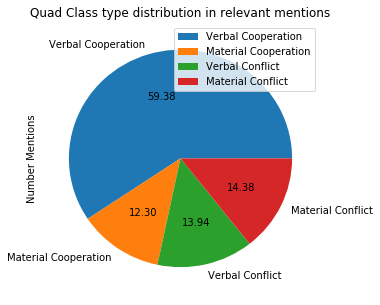

In [52]:
quad = med_cov_byQuadClass.groupby('QuadClass').agg(sum(med_cov_byQuadClass['Number Mentions']).alias('Number Mentions')).orderBy('QuadClass')

quad = get_piechart_data(quad,'Number Mentions','QuadClass')
quad.plot.pie(y='Number Mentions', autopct='%.2f',figsize=(5, 5),labels=get_class(list(quad.index)),title = 'Quad Class type distribution in relevant mentions')

## Location and Type of Event Biais

Next on our check list is to synthetize our findings, set up relevant visualisation and 